<a href="https://colab.research.google.com/github/JayellWolfe/DS-Unit-2-Regression-Classification/blob/master/W5D3_JW__assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 5.4MB/s 
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 1), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
   67ba221..d4c5f5c  master     -> origin/master
Updating 67ba221..d4c5f5c
Fast-forward
 .../assignment_regression_classification_4.ipynb   | 190 ++++
 module4/lesson_regression_classification_4.ipynb   | 970 +++++++++++++++++++++
 2 files changed, 1160 insertions(+)
 create mode 100644 module4/assignment_regression_c

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest

In [0]:
#drops out of range sales price

df = df[(df["SALE_PRICE"]>=100) & (df['SALE_PRICE']<=200000)]

In [0]:
#drop non 1 family
#remove building class catefory column 

df = df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') & (df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS')]
df.drop(columns=['BUILDING_CLASS_CATEGORY'], inplace=True)

In [0]:
#convert sales date to date time

df['SALE_DATE']= pd.to_datetime(df['SALE_DATE'])

In [77]:
#check columns

df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

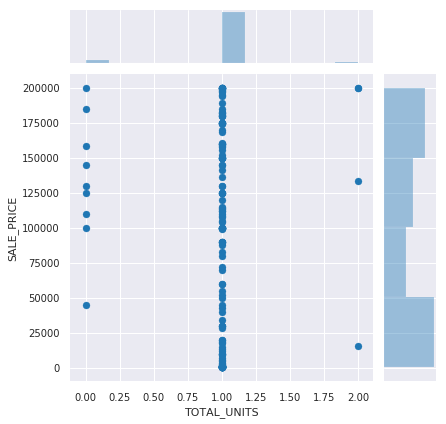

In [78]:
sns.set_style('darkgrid')
sns.jointplot(x=df['TOTAL_UNITS'], y=df['SALE_PRICE']);

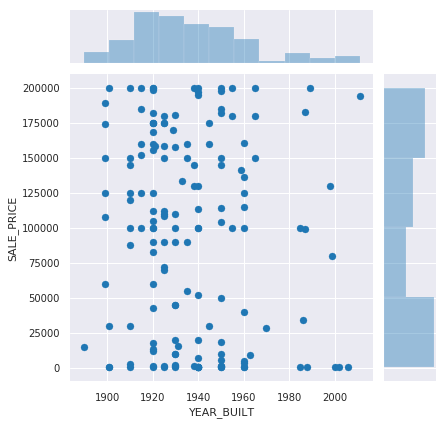

In [79]:
sns.set_style('darkgrid')
sns.jointplot(x=df['YEAR_BUILT'], y=df['SALE_PRICE']);

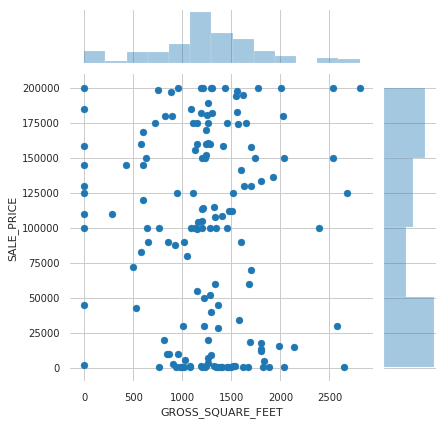

In [80]:
sns.set_style('whitegrid')
sns.jointplot(x=df['GROSS_SQUARE_FEET'], y=df['SALE_PRICE']);

In [81]:
df.head()

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
61,4,QUEENS VILLAGE,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
108,3,FLATBUSH-CENTRAL,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
354,4,FAR ROCKAWAY,1,15525,13,NaN,S1,1428 BEACH CHANNEL DRIVE,NaN,11691.0,1.0,1.0,2.0,"4,629",2808.0,1920.0,1,S1,200000,2019-01-03
673,4,REGO PARK,1,3107,178,NaN,A5,87-40 62ND ROAD,NaN,11374.0,1.0,0.0,1.0,"1,927",1520.0,1938.0,1,A5,1000,2019-01-04
741,3,MARINE PARK,1,8816,34,NaN,A5,2066 STUART STREET,NaN,11229.0,1.0,0.0,1.0,"2,000",1320.0,1950.0,1,A5,1000,2019-01-06


In [82]:
#check for unique variable

df['APARTMENT_NUMBER'].unique()

array([nan], dtype=object)

In [83]:
#check for occurances of "RP"

df['APARTMENT_NUMBER'].value_counts()

Series([], Name: APARTMENT_NUMBER, dtype: int64)

In [84]:
df[df['APARTMENT_NUMBER']=='RP.']

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE


In [85]:
#check for unique variables

df['TAX_CLASS_AT_TIME_OF_SALE'].unique()

array([1])

In [86]:
#check total unique values for address column

df['ADDRESS'].unique().shape

(151,)

In [87]:
#compare the unique values in address column to total rows

df.shape

(156, 20)

In [0]:
#remove these columns, remove tax class and building class 

df.drop(columns=['ADDRESS', 'EASE-MENT', 'TAX_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT'], inplace=True)

In [89]:
df.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
61,4,QUEENS VILLAGE,7918,72,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,A1,200000,2019-01-01
108,3,FLATBUSH-CENTRAL,5212,69,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,A1,125000,2019-01-02
354,4,FAR ROCKAWAY,15525,13,11691.0,1.0,1.0,2.0,"4,629",2808.0,1920.0,S1,200000,2019-01-03
673,4,REGO PARK,3107,178,11374.0,1.0,0.0,1.0,"1,927",1520.0,1938.0,A5,1000,2019-01-04
741,3,MARINE PARK,8816,34,11229.0,1.0,0.0,1.0,"2,000",1320.0,1950.0,A5,1000,2019-01-06


In [0]:
#change borough and zip code to string for categorical data 

df['BOROUGH'] = df['BOROUGH'].astype(str)
df['BOROUGH'] = df['ZIP_CODE'].astype(str)

In [0]:
top10Neigh = df['NEIGHBORHOOD'].value_counts()[:10].index
top10Zip = df['ZIP_CODE'].value_counts()[:10].index

df.loc[~df['NEIGHBORHOOD'].isin(top10Neigh), 'NEIGHBORHOOD'] = 'OTHER'
df.loc[~df['ZIP_CODE'].isin(top10Zip), 'ZIP_CODE'] = 'OTHER'

In [0]:
#split training and test data by dates

train = df[(df['SALE_DATE']>='2019-01') & (df['SALE_DATE']<='2019-03-31')].reset_index()
test = df[(df['SALE_DATE']>='2019-4-01') & (df['SALE_DATE']<='2019-04-30')].reset_index()

In [0]:
#ignore warnings

import warnings; warnings.simplefilter('ignore')

In [100]:
feats = ['BOROUGH', 'NEIGHBORHOOD', 'ZIP_CODE', 'BUILDING_CLASS_AT_TIME_OF_SALE']
targ = 'SALE_PRICE'

xTrain = train[feats]
yTrain = train[targ]

xTest = test[feats]
yTest = test[targ]

encoder2 = ce.OneHotEncoder(use_cat_names=True)
xTrainEnc = encoder2.fit_transform(xTrain)
xTestEnc = encoder2.transform(xTest)

scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(xTrainEnc)
xTestScaled = scaler.transform(xTestEnc)

for k in range(1,25):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    xTrainSel = selector.fit_transform(xTrainScaled, yTrain)
    xTestSel = selector.transform(xTestScaled)
    
    mod = LR()
    mod.fit(xTrainSel, yTrain)
    
    yPred = mod.predict(xTestSel)
    mae = mean_absolute_error(yTest, yPred)
    print(f'Test MAE: ${mae:,.0f}')              

1 features
Test MAE: $57,659
2 features
Test MAE: $58,122
3 features
Test MAE: $58,408
4 features
Test MAE: $57,552
5 features
Test MAE: $57,779
6 features
Test MAE: $58,674
7 features
Test MAE: $59,401
8 features
Test MAE: $59,219
9 features
Test MAE: $59,741
10 features
Test MAE: $58,874
11 features
Test MAE: $59,588
12 features
Test MAE: $54,690
13 features
Test MAE: $713,398,862,088,702,208
14 features
Test MAE: $45,498,004,412,897,256
15 features
Test MAE: $238,672,365,967,869,152
16 features
Test MAE: $833,235,393,793,846,912
17 features
Test MAE: $775,599,722,931,000,704
18 features
Test MAE: $484,737,040,947,366,656
19 features
Test MAE: $1,625,217,755,850,382,080
20 features
Test MAE: $89,608,146,575,623,296
21 features
Test MAE: $91,239,229,850,520,112
22 features
Test MAE: $29,477,016,983,204,412
23 features
Test MAE: $80,920,518,813,033,968
24 features
Test MAE: $324,273,316,281,815,616
